## Please note this model uses synthetic historical data and forward looking estimate are more appropriate

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlwings as xw
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## Connect to Excel and Load Simulation Parameters


In [2]:
book = xw.Book('Rent roll.xlsx')
sht = book.sheets['Operating income']

try:
    num_simulations = int(sht.range('C28').value)      # Number of simulations
    num_days = int(sht.range('C29').value) * 365       # Simulation period in days
    debt_yield_threshold = float(sht.range('C30').value)  # Debt yield covenant
    ltv_threshold = float(sht.range('C31').value)         # LTV covenant
    DSCR_threshold = float(sht.range('C32').value)        # DSCR covenant

    print(f"Number of simulations: {num_simulations}")
    print(f"Number of days: {num_days}")
    print(f"Debt Yield Threshold: {debt_yield_threshold}")
    print(f"LTV Threshold: {ltv_threshold}")
    print(f"DSCR Threshold: {DSCR_threshold}")
except Exception as e:
    print(f"Error loading parameters: {e}")

Number of simulations: 1000
Number of days: 1825
Debt Yield Threshold: 0.06
LTV Threshold: 0.9
DSCR Threshold: 1.5


## Load Historical Covenant Data from Excel

In [3]:
def load_excel_data(sheet, range_str, data_name):
    data = sheet.range(range_str).value
    if data is None:
        return None
    # Return list of non-None values
    if isinstance(data, (list, tuple)):
        return [x for x in data if x is not None]
    return [data] if data is not None else None

# Load covenant data from Excel
debt_yield = load_excel_data(sht, 'B20:AO20', 'Debt Yield')
ltv = load_excel_data(sht, 'B21:AO21', 'LTV')
Dscr = load_excel_data(sht, 'B22:AO22', 'DSCR')

if debt_yield and ltv and Dscr and len(debt_yield) > 1:
    data_dict = {
        'Debt_yield': debt_yield,
        'LTV': ltv,
        'DSCR': Dscr
    }
    print(f"Using historical data from Excel ({len(debt_yield)} periods)")
    periods_per_year = 4  # Quarterly data

Using historical data from Excel (40 periods)


## Calculating Stats from the Data

In [4]:
def calculate_statistics(data_dict, periods_per_year=4):
    
    
    # Ensure input data is valid
    if not data_dict or not all(len(v) > 1 for v in data_dict.values()):
        raise ValueError("Data dictionary must contain sequences with at least 2 values")
    
    # Compute log returns for each metric
    log_returns = {}
    for key, values in data_dict.items():
        arr = np.array(values)
        if np.any(arr <= 0):
            raise ValueError(f"Non-positive values found in {key}")
        log_ret = np.log(arr[1:] / arr[:-1])
        log_returns[key] = log_ret
    
    # Create DataFrame for returns
    rets_df = pd.DataFrame(log_returns)
    
    # Calculate mean and volatility (per period and annualized)
    stats_dict = {
        'mean_per_period': rets_df.mean(),
        'vol_per_period': rets_df.std(ddof=1),
        'mean_annual': rets_df.mean() * periods_per_year,
        'vol_annual': rets_df.std(ddof=1) * np.sqrt(periods_per_year)
    }
    
    stats_df = pd.DataFrame(stats_dict)
    corr_matrix = rets_df.corr()
    
    return stats_df, corr_matrix, rets_df

# Calculate statistics and show results
try:
    stats_df, corr_matrix, returns_df = calculate_statistics(data_dict)
    print("\nStatistics Summary:")
    print(stats_df)
    print("\nCorrelation Matrix:")
    print(corr_matrix)
except Exception as e:
    print(f"Error calculating statistics: {e}")


Statistics Summary:
            mean_per_period  vol_per_period  mean_annual  vol_annual
Debt_yield         0.008010        0.008770     0.032041    0.017540
LTV               -0.003441        0.008389    -0.013762    0.016777
DSCR               0.005444        0.068008     0.021776    0.136016

Correlation Matrix:
            Debt_yield       LTV      DSCR
Debt_yield    1.000000 -0.198504  0.023287
LTV          -0.198504  1.000000  0.241622
DSCR          0.023287  0.241622  1.000000


## Mean Reversion Parameters

In [5]:
def estimate_mean_reversion_parameters(historical_data, metric_name, periods_per_year=4):
    """Estimate mean reversion parameters for a metric using OLS regression."""
    data = np.array(historical_data)
    historical_mean = np.mean(data)
    if len(data) > 2:
        X_t = data[:-1]
        X_t1 = data[1:]
        X_centered = X_t - historical_mean
        dX = X_t1 - X_t
        model = sm.OLS(dX, X_centered)
        results = model.fit()
        dt = 1 / periods_per_year
        kappa_raw = -results.params[0] / dt
        kappa = np.clip(kappa_raw, 0.1, 5.0)
        half_life = np.log(2) / kappa if kappa > 0 else np.inf
    else:
        kappa = 0.5
        half_life = np.log(2) / kappa
    print(f"\n{metric_name} Mean Reversion Parameters:")
    print(f"  Historical Mean: {historical_mean:.4f}")
    print(f"  Reversion Speed (κ): {kappa:.3f} per year")
    print(f"  Half-life to mean: {half_life:.2f} years")
    return {'mean': historical_mean, 'kappa': kappa, 'half_life': half_life}

mean_reversion_params = {}
for metric_name, values in data_dict.items():
    mean_reversion_params[metric_name] = estimate_mean_reversion_parameters(values, metric_name, periods_per_year=4)


Debt_yield Mean Reversion Parameters:
  Historical Mean: 0.0750
  Reversion Speed (κ): 0.100 per year
  Half-life to mean: 6.93 years

LTV Mean Reversion Parameters:
  Historical Mean: 0.8111
  Reversion Speed (κ): 0.100 per year
  Half-life to mean: 6.93 years

DSCR Mean Reversion Parameters:
  Historical Mean: 2.0640
  Reversion Speed (κ): 0.526 per year
  Half-life to mean: 1.32 years


## Running Monte Carlo Simulation

In [6]:
def generate_sample_data_historical(seed=42):
    """
    Simulate metric paths using mean reversion and correlated shocks.
    Returns simulated paths for Debt Yield, LTV, and DSCR.
    """
    np.random.seed(seed)
    vol_debt_yield = stats_df.loc['Debt_yield', 'vol_annual']
    vol_ltv = stats_df.loc['LTV', 'vol_annual']
    vol_dscr = stats_df.loc['DSCR', 'vol_annual']
    long_term_means = {
        'debt_yield': mean_reversion_params['Debt_yield']['mean'],
        'ltv': mean_reversion_params['LTV']['mean'],
        'dscr': mean_reversion_params['DSCR']['mean']
    }
    reversion_speeds = {
        'debt_yield': mean_reversion_params['Debt_yield']['kappa'],
        'ltv': mean_reversion_params['LTV']['kappa'],
        'dscr': mean_reversion_params['DSCR']['kappa']
    }
    dt = 1/365
    daily_vol = {
        'debt': vol_debt_yield * np.sqrt(dt),
        'ltv': vol_ltv * np.sqrt(dt),
        'dscr': vol_dscr * np.sqrt(dt)
    }
    debt_yield_paths = np.zeros((num_simulations, num_days))
    ltv_paths = np.zeros((num_simulations, num_days))
    dscr_paths = np.zeros((num_simulations, num_days))
    debt_yield_paths[:, 0] = debt_yield[-1]
    ltv_paths[:, 0] = ltv[-1]
    dscr_paths[:, 0] = Dscr[-1]
    cov_matrix = corr_matrix.values
    n_vars = len(cov_matrix)
    all_shocks = np.random.multivariate_normal(np.zeros(n_vars), cov_matrix, size=(num_simulations, num_days-1))
    for t in range(1, num_days):
        shocks = all_shocks[:, t-1, :]
        # Debt Yield
        drift_dy = reversion_speeds['debt_yield'] * (long_term_means['debt_yield'] - debt_yield_paths[:, t-1]) * dt
        diffusion_dy = daily_vol['debt'] * debt_yield_paths[:, t-1] * shocks[:, 0]
        debt_yield_paths[:, t] = debt_yield_paths[:, t-1] + drift_dy + diffusion_dy
        # LTV
        drift_ltv = reversion_speeds['ltv'] * (long_term_means['ltv'] - ltv_paths[:, t-1]) * dt
        diffusion_ltv = daily_vol['ltv'] * ltv_paths[:, t-1] * shocks[:, 1]
        ltv_paths[:, t] = ltv_paths[:, t-1] + drift_ltv + diffusion_ltv
        # DSCR
        drift_dscr = reversion_speeds['dscr'] * (long_term_means['dscr'] - dscr_paths[:, t-1]) * dt
        diffusion_dscr = daily_vol['dscr'] * dscr_paths[:, t-1] * shocks[:, 2]
        dscr_paths[:, t] = dscr_paths[:, t-1] + drift_dscr + diffusion_dscr
        # Ensure positive values
        debt_yield_paths[:, t] = np.maximum(debt_yield_paths[:, t], 0.001)
        ltv_paths[:, t] = np.maximum(ltv_paths[:, t], 0.001)
        dscr_paths[:, t] = np.maximum(dscr_paths[:, t], 0.001)
    return {'Debt_yield': debt_yield_paths, 'LTV': ltv_paths, 'DSCR': dscr_paths}

simulation_data = generate_sample_data_historical()

In [7]:
thresholds = {
    'Debt_yield': debt_yield_threshold,
    'LTV': ltv_threshold,
    'DSCR': DSCR_threshold
}

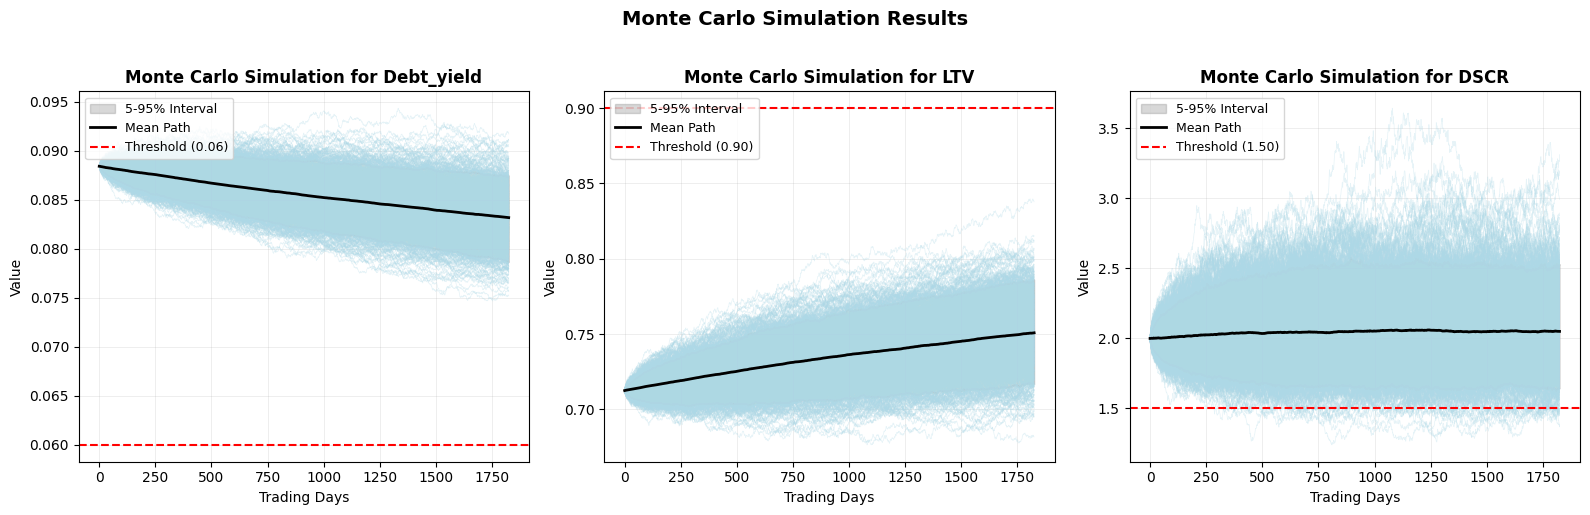

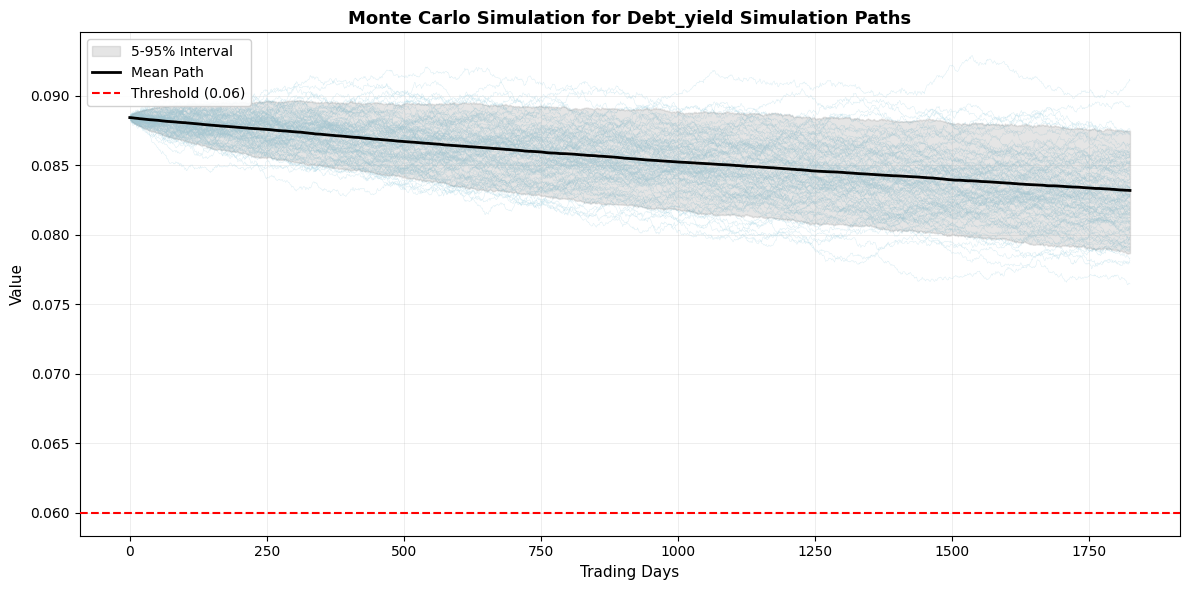

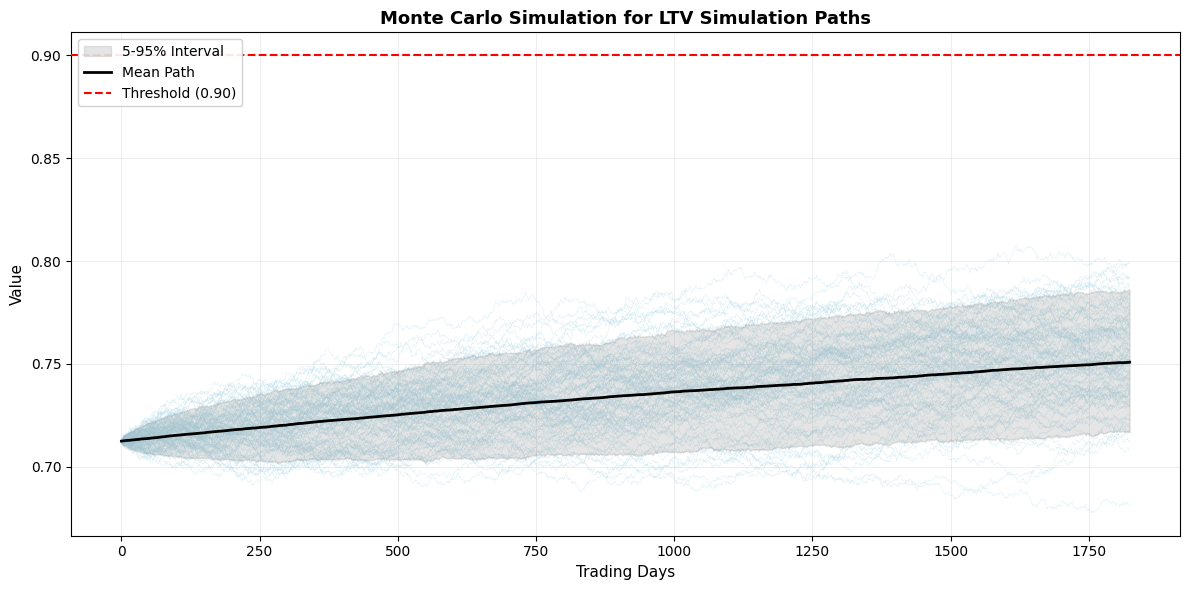

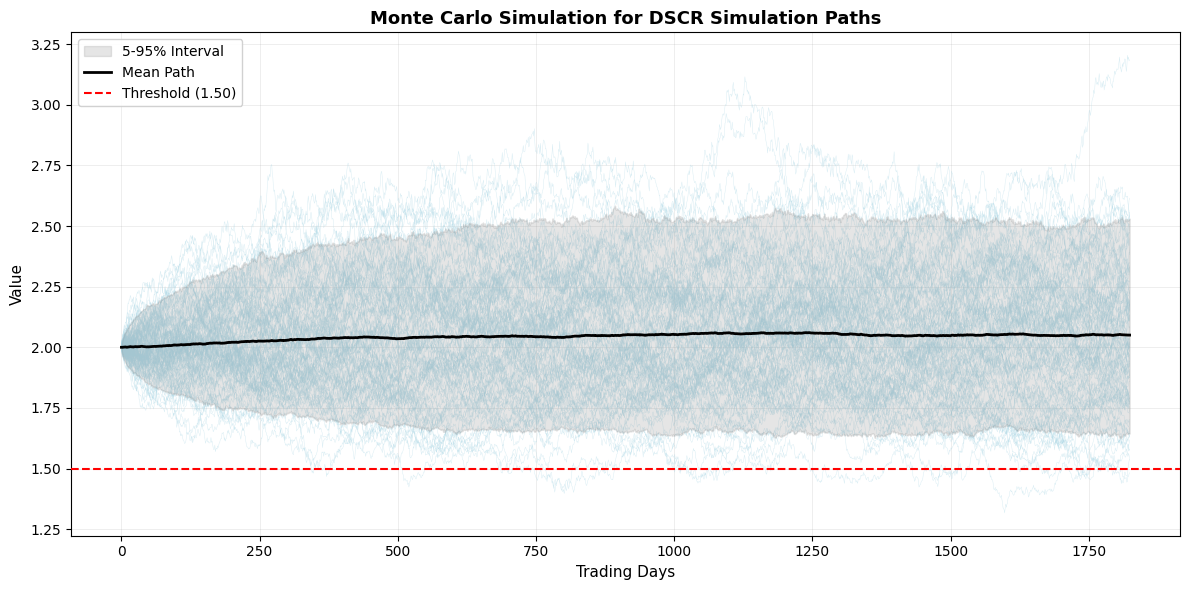

In [8]:
def plot_monte_carlo_results(simulation_paths, metric_names, thresholds=None):
    """Plot Monte Carlo simulation results for multiple metrics."""
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(1, n_metrics, figsize=(16, 5))
    if n_metrics == 1:
        axes = [axes]
    for idx, metric in enumerate(metric_names):
        ax = axes[idx]
        paths = simulation_paths[metric]
        n_simulations, num_days = paths.shape
        days = np.arange(num_days)
        for i in range(n_simulations):
            ax.plot(days, paths[i, :], color='lightblue', alpha=0.3, linewidth=0.5)
        mean_path = np.mean(paths, axis=0)
        percentile_5 = np.percentile(paths, 5, axis=0)
        percentile_95 = np.percentile(paths, 95, axis=0)
        ax.fill_between(days, percentile_5, percentile_95, color='grey', alpha=0.3, label='5-95% Interval')
        ax.plot(days, mean_path, color='black', linewidth=2, label='Mean Path')
        if thresholds and metric in thresholds and thresholds[metric] is not None:
            ax.axhline(y=thresholds[metric], color='red', linestyle='--', linewidth=1.5, label=f'Threshold ({thresholds[metric]:.2f})')
        ax.set_xlabel('Trading Days', fontsize=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.set_title(f'Monte Carlo Simulation for {metric}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.legend(loc='upper left', fontsize=9)
        ax.set_facecolor('white')
    plt.suptitle('Monte Carlo Simulation Results', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_single_monte_carlo(paths, metric_name, threshold=None, figsize=(12, 6)):
    """Plot Monte Carlo simulation results for a single metric."""
    fig, ax = plt.subplots(figsize=figsize)
    n_simulations, num_days = paths.shape
    days = np.arange(num_days)
    max_paths_to_show = min(100, n_simulations)
    indices = np.random.choice(n_simulations, max_paths_to_show, replace=False)
    for i in indices:
        ax.plot(days, paths[i, :], color='lightblue', alpha=0.5, linewidth=0.3)
    mean_path = np.mean(paths, axis=0)
    percentile_5 = np.percentile(paths, 5, axis=0)
    percentile_95 = np.percentile(paths, 95, axis=0)
    ax.fill_between(days, percentile_5, percentile_95, color='grey', alpha=0.2, label='5-95% Interval', zorder=2)
    ax.plot(days, mean_path, color='black', linewidth=2, label='Mean Path', zorder=3)
    if threshold is not None:
        ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5, label=f'Threshold ({threshold:.2f})', zorder=4)
    ax.set_xlabel('Trading Days', fontsize=11)
    ax.set_ylabel('Value', fontsize=11)
    ax.set_title(f'Monte Carlo Simulation for {metric_name}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.show()
        
        
metric_names = ['Debt_yield', 'LTV', 'DSCR']
plot_monte_carlo_results(simulation_data, metric_names, thresholds)
    
for metric in metric_names:
        thr = thresholds.get(metric)
        plot_single_monte_carlo(
            simulation_data[metric], 
            f'{metric} Simulation Paths',
            threshold=thr
        )

## Calculating Covenant Breach Probabilities

In [9]:
def _get_results_and_names():
    
    if 'simulation_data' in globals():
        names = list(simulation_data.keys())
        arrs = [simulation_data[k] for k in names]   # Each: (n_sim, n_days)
        stacked = np.stack(arrs, axis=2)             # (n_sim, n_days, n_vars)
        return stacked, names
    raise RuntimeError("No simulation_results or simulation_data found")

def breach_probabilities(results, var_names, thresholds, ignore_t0=True):
    
    n_sim = results.shape[0]
    any_breach_combined = np.zeros(n_sim, dtype=bool)
    out = {}

    for name in var_names:
        thr = thresholds.get(name, thresholds.get(name.lower()))
        if thr is None:
            out[name] = None
            continue

        idx = var_names.index(name)
        vals = results[:, :, idx]
        vals_for_any = vals[:, 1:] if ignore_t0 and vals.shape[1] > 1 else vals

        # Breach logic: Debt Yield & DSCR breach if BELOW threshold, LTV if ABOVE
        if 'debt' in name.lower() or 'yield' in name.lower():
            any_breach = np.any(vals_for_any < thr, axis=1)
        elif 'ltv' in name.lower():
            any_breach = np.any(vals_for_any > thr, axis=1)
        elif 'dscr' in name.lower():
            any_breach = np.any(vals_for_any < thr, axis=1)

        out[name] = any_breach.mean() * 100
        any_breach_combined |= any_breach

    out['Combined_any_pct'] = any_breach_combined.mean() * 100
    return out

# Run the breach probability calculation
results, var_names = _get_results_and_names()
probs = breach_probabilities(results, var_names, thresholds, ignore_t0=True)

# Print results
for k, v in probs.items():
    if k == 'Combined_any_pct':
        print(f"Combined any-time breach: {v:.2f}%")
    elif v is None:
        print(f"{k}: threshold not provided")
    else:
        print(f"{k}: any-time breach = {v:.2f}%")

Debt_yield: any-time breach = 0.00%
LTV: any-time breach = 0.00%
DSCR: any-time breach = 11.10%
Combined any-time breach: 11.10%


## Simulation Summary Statistics

In [14]:
def print_simulation_summary(simulation_data, thresholds):
    
    print("SIMULATION SUMMARY")

    
    for metric, paths in simulation_data.items():
        final_values = paths[:, -1]
        threshold = thresholds.get(metric)
        
        print(f"\n{metric}:")
        print(f"  Initial value: {paths[0, 0]:.3f}")
        print(f"  Final mean: {np.mean(final_values):.3f}")
        print(f"  Final std dev: {np.std(final_values):.3f}")
        print(f"  5th percentile: {np.percentile(final_values, 5):.3f}")
        print(f"  95th percentile: {np.percentile(final_values, 95):.3f}")
        
        if threshold is not None:
            if 'ltv' in metric.lower():
                breach_count = np.sum(final_values > threshold)
            else:  # Debt Yield and DSCR breach if below threshold
                breach_count = np.sum(final_values < threshold)
            print(f"  Final breach rate: {breach_count / len(final_values) * 100:.1f}%")

# Print summary statistics after running the simulation
print_simulation_summary(simulation_data, thresholds)  

SIMULATION SUMMARY

Debt_yield:
  Initial value: 0.088
  Final mean: 0.083
  Final std dev: 0.003
  5th percentile: 0.079
  95th percentile: 0.087
  Final breach rate: 0.0%

LTV:
  Initial value: 0.713
  Final mean: 0.751
  Final std dev: 0.021
  5th percentile: 0.717
  95th percentile: 0.786
  Final breach rate: 0.0%

DSCR:
  Initial value: 2.000
  Final mean: 2.050
  Final std dev: 0.270
  5th percentile: 1.644
  95th percentile: 2.530
  Final breach rate: 1.1%
